Creating a standardized pipeline for the pre-processing of the quarterly data from 2019 - 2024 based on results from initial_exploration file

In [17]:
# imports
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests
import re
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
pip install psycopg2

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.2 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.2 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.2 MB 730.2 kB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.2 MB 907.1 kB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# variable initializations

# path variables
current_path = os.getcwd()

data_q24 = r'data\\faers_ascii_2024q4'
directory_path = os.path.join(current_path, data_q24)

# filename initials
demography = "DEMO"
outcome = "OUTC"
reaction = "REAC"
indication = "INDI"
report_src = "RPSR"
therapy ='THER'
drug = 'DRUG'

# drugnames
antihistamines = ["Fexofenadine", "Cetirizine", "Loratadine", "Levocetirizine"]


In [340]:
# function to read faers file
def read_faers_file(folder,file_name, delimiter="$"):
  file_path = os.path.join(folder, file_name)
  df = pd.read_csv(file_path, sep=delimiter, dtype=str, encoding='ISO-8859-1', on_bad_lines='skip')
                   
  df['caseid'] = pd.to_numeric(df['caseid'], errors='coerce')
  return df

In [4]:
# searching in the drug dataset where antihistamines are the primary suspect
def filter_antihistamines(drug_df):
  return drug_df[(drug_df["drugname"].str.contains('|'.join(antihistamines), case=False, na=False))
                 & (drug_df["role_cod"] == "PS")]

In [5]:
def merge_faers_data(filtered_drug_df, reac_df, demo_df, outc_df,rpsr_df):
    merged_df = (
        filtered_drug_df
        .merge(reac_df, on="caseid", how="left",suffixes=('', '_reac'))
        .merge(demo_df, on="caseid", how="left", suffixes=('', '_demo'))
        .merge(outc_df, on="caseid", how="left", suffixes=('', '_outc'))
        .merge(rpsr_df, on="caseid", how="left",suffixes=('', '_rpsr'))
    )
    return merged_df

In [305]:
#processing the data
def process_faers_dataset(working_dir, q_name):
    folder = working_dir
    drug_df = read_faers_file(folder,f'{drug}{q_name}.txt')
    reac_df = read_faers_file(folder,f"{reaction}{q_name}.txt")
    demo_df = read_faers_file(folder,f"{demography}{q_name}.txt")
    outc_df = read_faers_file(folder,f"{outcome}{q_name}.txt")
    rpsr_df = read_faers_file(folder,f"{report_src}{q_name}.txt")

    filtered_drugs = filter_antihistamines(drug_df)
    final_df = merge_faers_data(filtered_drugs, reac_df, demo_df, outc_df, rpsr_df)
    return final_df

In [163]:
# merging the dataset as there are multiple outc_cod for same pt, drug and event date
def merge_dataset(dataframe):
    df = dataframe.copy()
    group_cols = ['primaryid', 'caseid', 'drugname', 'event_dt', 'pt']

    merged_df = df.groupby(group_cols, as_index=False).agg({
    'outc_cod': lambda x: ','.join(x.dropna().astype(str)),  # Merge outcome codes
    **{col: lambda x: ','.join(x.astype(str).unique()) for col in df.columns if col not in group_cols + ['outc_cod']}
    })
    return merged_df

In [39]:
def convert_nan_to_npnan(df, column_name):
    df = df.copy()
    df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)
    
    return df

In [8]:
def convert_str_to_float(df, column_name):
    df = df.copy()
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')  # Ensures NaNs instead of errors
    return df

In [51]:
def type_conversion(dataframe, column_name,tp):
    df = dataframe.copy()
    df[column_name] = df[column_name].astype(tp)
    return df

In [460]:
class FAERSPipeline:
    def __init__(self, raw_df):
        self.raw_df = raw_df.copy()
        self.processed_df = None
    def drop_irrelevant_columns(self):
        """
        drops unnecessary columns.
        """
        df = self.raw_df.copy()
        
        
        for col in df.columns:
            df = convert_nan_to_npnan(df, col)
    
        columns_to_drop = [
            'val_vbm', 'lot_num', 'exp_dt', 'nda_num', 'auth_num', 'mfr_num', 
            'mfr_sndr', 'lit_ref', 'primaryid_reac', 'to_mfr'
        ]
    
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
        self.processed_df = df
        return self

    def encode_categorical_variables(self):
        """
        encodes categorical variables.
        """
        df = self.processed_df.copy()
    
    
        # binary conversion
        if 'i_f_code' in df.columns:
            df['i_f_code'] = df['i_f_code'].map({'Y': 1, 'N': 0})
    
        # ordinal encoding
        ordinal_cols = ['rechal', 'dechal', 'drug_rec_act']
        for col in ordinal_cols:
            if col in df.columns:
                df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    
        # one-hot encoding for nominal categorical
        df = pd.get_dummies(df, columns=['route', 'dose_form', 'dose_freq'], drop_first=True)
        self.processed_df = df
        return self


    def convert_date_columns(self):
        """
        standardizing the date columns
        """
        df = self.processed_df.copy()
        
        # datetime columns list
        date_cols = ['event_dt', 'mfr_dt', 'init_fda_dt', 'fda_dt', 'rept_dt']
        # for col in date_cols:
        #     if col in df.columns:
        #         df = convert_nan_to_npnan(df, col)
    
        # conversion to datetime format
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')
        self.processed_df = df
        return self

    def convert_age_to_years(self):
        df = self.processed_df.copy()  
        
        df['age'] = df['age'].astype(float)
    
        # converting different values into years
        df.loc[df['age_cod'] == 'MON', 'age'] /= 12        # months 
        df.loc[df['age_cod'] == 'WK', 'age'] /= 52.1429    # weeks
        df.loc[df['age_cod'] == 'DY', 'age'] /= 365        # days
        df.loc[df['age_cod'] == 'HR', 'age'] /= 8760       # hours
        df.loc[df['age_cod'] == 'DEC', 'age'] *= 10        # decades
        self.processed_df = df
        return self
    def age_imputation(self):
        df = self.processed_df.copy()  
        median_age_by_drug = df.groupby('drugname')['age'].median()
        df['age'] = df.apply(lambda row: median_age_by_drug[row['drugname']] if pd.isna(row['age']) else row['age'], axis=1)
        self.processed_df = df
        return self

    def clean_name_pt(self):
        df = self.processed_df.copy() 
        df['drugname'] = df['drugname'].str.upper().str.strip()
        df['pt'] = df['pt'].str.lower().str.strip()
        self.processed_df = df
        return self

    def final_normalize_drug_names(self, column='normalized_drugname'):
        """
        Further normalizes drug names by handling variations in formatting, 
        synonyms, and redundant terms.
        """
        df = self.processed_df.copy()
    
        # converting separators to a uniform format
        df[column] = df['drugname'].str.replace(r'[\\]', ' / ', regex=True)
        df[column] = df[column].str.replace(r'\s+', ' ', regex=True).str.strip()  # Remove extra spaces
    
        # known variations mapping
        drug_mapping = {
            "CETIRIZINE HYDROCHLORIDE": "CETIRIZINE",
            "FEXOFENADINE HYDROCHLORIDE": "FEXOFENADINE",
            "LEVOCETIRIZINE DIHYDROCHLORIDE": "LEVOCETIRIZINE",
            # "CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY": "CETIRIZINE",
            "CETIRIZINE HYDROCHLORIDE PSEUDOEPHEDRINE HYDROCHLORIDE": "CETIRIZINE / PSEUDOEPHEDRINE",
            "LORATADINE PSEUDOEPHEDRINE SULFATE": "LORATADINE / PSEUDOEPHEDRINE",
            "LORATADINE AND PSEUDOEPHEDRINE SULFATE": "LORATADINE / PSEUDOEPHEDRINE",
            r"LORATADINE / PSEUDOEPHEDRINE SULFATE": "LORATADINE / PSEUDOEPHEDRINE",
            r"CETIRIZINE HYDROCHLORIDE / PSEUDOEPHEDRINE HYDROCHLORIDE": "CETIRIZINE / PSEUDOEPHEDRINE",
        }
    
        df[column] = df['drugname'].replace(drug_mapping)
        self.processed_df = df
        return self


    def convert_dose_units(self):
        """
        converting dose amounts to milligrams
        """
        df = self.processed_df.copy()
        
        df.loc[df['dose_unit'] == 'MG', 'converted_dose_amt'] = df.loc[df['dose_unit'] == 'MG', 'dose_amt']
        # 1 ML = 1 MG 
        df.loc[df['dose_unit'] == 'ML', 'converted_dose_amt'] = df.loc[df['dose_unit'] == 'ML', 'dose_amt'] * 1
        
        # assuming 1 GTT ≈ 0.05 MG
        df.loc[df['dose_unit'] == 'GTT', 'converted_dose_amt'] = df.loc[df['dose_unit'] == 'GTT', 'dose_amt'] * 0.05
        
        
        df['converted_dose_amt'] = pd.to_numeric(df['converted_dose_amt'], errors='coerce')
        self.processed_df = df
        return self

    def standardize_weight(self):
        df = self.processed_df.copy()
    
        if 'wt' not in df.columns:
            raise ValueError("Column 'wt' not found in DataFrame")
    
        
        df = convert_str_to_float(df, 'wt')
        df = convert_nan_to_npnan(df, 'wt')
    
        # converted_wt column to store the converted weightss
        df['converted_wt'] = df['wt']
    
        # lb to kg conversion
        if 'LB' in df['wt_cod'].dropna().unique():  
            df.loc[df['wt_cod'] == 'LB', 'converted_wt'] *= 0.453592 

        self.processed_df = df
        return self

    def get_processed_data(self):
        return self.processed_df

In [165]:
data_f = process_faers_dataset()

In [201]:
data_f.columns

Index(['primaryid', 'caseid', 'drug_seq', 'role_cod', 'drugname', 'prod_ai',
       'val_vbm', 'route', 'dose_vbm', 'cum_dose_chr', 'cum_dose_unit',
       'dechal', 'rechal', 'lot_num', 'exp_dt', 'nda_num', 'dose_amt',
       'dose_unit', 'dose_form', 'dose_freq', 'primaryid_reac', 'pt',
       'drug_rec_act', 'primaryid_demo', 'caseversion', 'i_f_code', 'event_dt',
       'mfr_dt', 'init_fda_dt', 'fda_dt', 'rept_cod', 'auth_num', 'mfr_num',
       'mfr_sndr', 'lit_ref', 'age', 'age_cod', 'age_grp', 'sex', 'e_sub',
       'wt', 'wt_cod', 'rept_dt', 'to_mfr', 'occp_cod', 'reporter_country',
       'occr_country', 'primaryid_outc', 'outc_cod', 'primaryid_rpsr',
       'rpsr_cod'],
      dtype='object')

In [175]:
counter = len(data_f.columns) - 1
while counter >= 0:
    df = data_f
    new_df = convert_nan_to_npnan(df, data_f.columns[counter])
    data_f = new_df
    counter -= 1
    
    

In [177]:
merged_df = merge_dataset(data_f)

In [179]:
merged_df[['primaryid','caseid','drugname','pt','event_dt','outc_cod']].head(10)

,primaryid,caseid,drugname,pt,event_dt,outc_cod
0,1454484512,14544845,CETIRIZINE,Drug abuse,20110101,"OT,HO,LT"
1,1454484512,14544845,CETIRIZINE,Drug-induced liver injury,20110101,"OT,HO,LT"
2,1454484512,14544845,CETIRIZINE,Hepatic necrosis,20110101,"OT,HO,LT"
3,1454484512,14544845,CETIRIZINE,Intentional overdose,20110101,"OT,HO,LT"
4,1454484512,14544845,CETIRIZINE,Off label use,20110101,"OT,HO,LT"
5,1454484512,14544845,CETIRIZINE,Suicide attempt,20110101,"OT,HO,LT"
6,180385345,18038534,CETIRIZINE,Condition aggravated,20200623,"LT,OT"
7,180385345,18038534,CETIRIZINE,Epidermolysis bullosa,20200623,"LT,OT"
8,180385345,18038534,CETIRIZINE,Leukopenia,20200623,"LT,OT"
9,180385345,18038534,CETIRIZINE,Lymphopenia,20200623,"LT,OT"


In [183]:
counter = len(merged_df.columns) - 1
while counter >= 0:
    df = merged_df
    new_df = convert_nan_to_npnan(df, merged_df.columns[counter])
    merged_df = new_df
    counter -= 1

C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)


In [187]:
age_converted_df = type_conversion(merged_df,'age','Int64')

In [189]:
age_converted_df['age'].max()

92

In [191]:
column_list =[ 'dose_amt', 'wt']

for c in column_list:
    df = age_converted_df.copy()
    modified_df = convert_str_to_float(df,c)
    age_converted_df = modified_df
    

In [221]:
# processing the pipeline for each records
pipeline = FAERSPipeline(age_converted_df)
processed = (
    pipeline
    .drop_irrelevant_columns()
    .encode_categorical_variables()
    .convert_date_columns()
    .convert_age_to_years()
    .age_imputation()
    .clean_name_pt()
    .final_normalize_drug_names()
    .convert_dose_units()
    .standardize_weight()
    .get_processed_data()
)

In [223]:
processed.columns

Index(['primaryid', 'caseid', 'drugname', 'event_dt', 'pt', 'outc_cod',
       'drug_seq', 'role_cod', 'prod_ai', 'dose_vbm', 'cum_dose_chr',
       'cum_dose_unit', 'dechal', 'rechal', 'dose_amt', 'dose_unit',
       'drug_rec_act', 'primaryid_demo', 'caseversion', 'i_f_code', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'rept_cod', 'age', 'age_cod', 'age_grp', 'sex',
       'e_sub', 'wt', 'wt_cod', 'rept_dt', 'occp_cod', 'reporter_country',
       'occr_country', 'primaryid_outc', 'primaryid_rpsr', 'rpsr_cod',
       'route_Oral', 'route_Transplacental', 'route_Unknown',
       'dose_form_Capsule, hard', 'dose_form_Film-coated tablet',
       'dose_form_NON COMPANY FORMULATION', 'dose_form_Oral drops',
       'dose_form_Oral solution', 'dose_form_Orodispersible tablet',
       'dose_form_Syrup', 'dose_form_TABLET, ORALLY DISINTEGRATING',
       'dose_form_Tablet', 'dose_form_Unknown', 'dose_freq_QD',
       'normalized_drugname', 'converted_dose_amt', 'converted_wt'],
      dtype='objec

In [229]:
processed.head(10)

,primaryid,caseid,drugname,event_dt,pt,outc_cod,drug_seq,role_cod,prod_ai,dose_vbm,...,dose_form_Orodispersible tablet,dose_form_Syrup,"dose_form_TABLET, ORALLY DISINTEGRATING",dose_form_Tablet,dose_form_Unknown,dose_freq_QD,normalized_drugname,converted_dose_amt,converted_wt,data_quarter
0,1454484512,14544845,CETIRIZINE,2011-01-01,drug abuse,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
1,1454484512,14544845,CETIRIZINE,2011-01-01,drug-induced liver injury,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
2,1454484512,14544845,CETIRIZINE,2011-01-01,hepatic necrosis,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
3,1454484512,14544845,CETIRIZINE,2011-01-01,intentional overdose,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
4,1454484512,14544845,CETIRIZINE,2011-01-01,off label use,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
5,1454484512,14544845,CETIRIZINE,2011-01-01,suicide attempt,"OT,HO,LT",3,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,NaN,24
6,180385345,18038534,CETIRIZINE,2020-06-23,condition aggravated,"LT,OT",1,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,67.0,24
7,180385345,18038534,CETIRIZINE,2020-06-23,epidermolysis bullosa,"LT,OT",1,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,67.0,24
8,180385345,18038534,CETIRIZINE,2020-06-23,leukopenia,"LT,OT",1,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,67.0,24
9,180385345,18038534,CETIRIZINE,2020-06-23,lymphopenia,"LT,OT",1,PS,CETIRIZINE HYDROCHLORIDE,UNK,...,False,False,False,False,False,False,CETIRIZINE,NaN,67.0,24


In [227]:
processed['data_quarter']= 24

Ingesting the processed data into the PostgreSQL database

In [474]:
def ingest_faers_data(processed_df, db_params):
    """
    ingests preprocessed FAERS data into PostgreSQL database.
    """
    try:
        conn = psycopg2.connect(**db_params)
        cursor = conn.cursor()

        for _, row in processed_df.iterrows():
            # into faers_cases
            cursor.execute("""
                INSERT INTO faers_cases (primaryid, caseid, caseversion, event_dt, rept_dt, sex, age, age_cod, age_grp, wt, converted_wt, wt_cod, occp_cod, reporter_country, occr_country, data_quarter)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                ON CONFLICT (primaryid, caseid, caseversion) DO NOTHING;
            """, (
                row['primaryid'], row['caseid'], row['caseversion'], row['event_dt'],row['rept_dt'],
                 row['sex'], row['age'], row['age_cod'], row['age_grp'],row['wt'],row['converted_wt'],row['wt_cod'],
                row['occp_cod'], row['reporter_country'], row['occr_country'],
                row['data_quarter']
            ))

            # into faers_drugs
            cursor.execute("""
                INSERT INTO faers_drugs (
                    primaryid, caseid, caseversion, role_cod, drugname, normalized_drugname, prod_ai, formulation_type,
                    dose_amt, converted_dose_amt, dose_unit,
                    is_oral, is_transplacental, is_unknown_route,
                    is_capsule, is_tablet, is_syrup, is_oral_solution,
                     is_unknown_form,
                     is_qd, data_quarter
                )
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
            """, (
                row['primaryid'], row['caseid'], row['caseversion'], row['role_cod'],
                row['drugname'], row['normalized_drugname'],row['prod_ai'],row['formulation_type'],
                row['dose_amt'], row['converted_dose_amt'], row['dose_unit'],
                row.get('route_Oral', False), row.get('route_Transplacental', False), row.get('route_Unknown', False),
                row.get('dose_form_Capsule, hard', False), row.get('dose_form_Tablet', False),
                row.get('dose_form_Syrup', False), row.get('dose_form_Oral solution', False),
                row.get('dose_form_Unknown', False), 
                row.get('dose_freq_QD', False),
                row['data_quarter']
            ))


            # faers_reactions
            cursor.execute("""
                INSERT INTO faers_reactions (primaryid, caseid, caseversion, pt, outc_cod, event_dt, data_quarter)
                VALUES (%s, %s, %s, %s, %s, %s, %s);
            """, (
                row['primaryid'], row['caseid'], row['caseversion'], row['pt'], row['outc_cod'], row['event_dt'], row['data_quarter']
            ))

        conn.commit()
        cursor.close()
        conn.close()
        print("Data ingestion complete.")

    except Exception as e:
        print("Error during ingestion:", e)


In [464]:
# database parameters
db_params = {
    'host': 'localhost',
    'port': 5432,
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres'
}



In [261]:
ingest_faers_data(processed, db_params)

Data ingestion complete.


In [470]:
def classify_formulation_type(drugname):
    
    """
    Classifies the drug formulation as 'children', 'adult', or 'unspecified'
    based on keywords in the drug name.
    """
    drugname = drugname.lower() if isinstance(drugname, str) else ''
    
    # Patterns for children's formulations
    children_patterns = [
        r'\bchild\b', r'\bchildren\b', r'\bkid\b', r'\bjunior\b',
        r'\b2 years\b', r'\bunder 12\b', r'\bages? ?\d+\b', r'\bchewable\b'
    ]
    
    # Patterns for adult formulations
    adult_patterns = [
        r'\badult\b', r'\b18+\b', r'\btablet\b', r'\bextra strength\b'
    ]

    for pattern in children_patterns:
        if re.search(pattern, drugname):
            return 'children'

    for pattern in adult_patterns:
        if re.search(pattern, drugname):
            return 'adult'

    return 'unspecified'

The codeblock below runs for every quarterly data from 2019 Q1 to 2024 Q4, standardizes them and ingests them into the database

In [480]:
current_path = os.path.join(os.getcwd(),'data\\')
for folder in os.listdir(current_path):
    print(folder)
    working_dir = os.path.join(current_path, folder)
    q_name = folder.split('_')[2].upper()
    # print(q_name[2:])   
    data_f = process_faers_dataset(working_dir,q_name[2:])
    counter = len(data_f.columns) - 1
    while counter >= 0:
        df = data_f
        new_df = convert_nan_to_npnan(df, data_f.columns[counter])
        data_f = new_df
        counter -= 1
    
    merged_df = merge_dataset(data_f)
    counter = len(merged_df.columns) - 1
    while counter >= 0:
        df = merged_df
        new_df = convert_nan_to_npnan(df, merged_df.columns[counter])
        merged_df = new_df
        counter -= 1
    age_converted_df = type_conversion(merged_df,'age','Int64')
    column_list =[ 'dose_amt', 'wt']
    for c in column_list:
        df = age_converted_df.copy()
        modified_df = convert_str_to_float(df,c)
        age_converted_df = modified_df
    pipeline = FAERSPipeline(age_converted_df)
    processed = (
        pipeline
        .drop_irrelevant_columns()
        .encode_categorical_variables()
        .convert_date_columns()
        .convert_age_to_years()
        .age_imputation()
        .clean_name_pt()
        .final_normalize_drug_names()
        .convert_dose_units()
        .standardize_weight()
        .get_processed_data()
    ) 
    processed['data_quarter']= q_name
    processed['formulation_type'] = processed['drugname'].apply(classify_formulation_type)
    datetime_columns = ['event_dt', 'rept_dt']
    processed = processed.replace({np.NaN: None})
    ingest_faers_data(processed, db_params)


faers_ascii_2023q3
Data ingestion complete.
faers_ascii_2023q4


C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)


Data ingestion complete.
faers_ascii_2024q1
Data ingestion complete.
faers_ascii_2024q2


C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)


Data ingestion complete.
faers_ascii_2024q3


C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)
C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)


Data ingestion complete.
faers_ascii_2024q4


C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)
C:\Users\utsav\AppData\Local\Temp\ipykernel_20188\2800444819.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_name] = df[column_name].replace(['nan', 'NaN', 'None'], np.nan)


Data ingestion complete.


In [458]:
processed[processed['normalized_drugname']== 'CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY'][['drugname','normalized_drugname','prod_ai']].head(20)

,drugname,normalized_drugname,prod_ai
144,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
145,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
146,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
147,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
148,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
149,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
150,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
151,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
152,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE
153,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CHILDRENS CETIRIZINE HYDROCHLORIDE ALLERGY,CETIRIZINE HYDROCHLORIDE


Data Exploration after complete ingestion of the dataset into the database

In [364]:
def get_db_connection():
    user = 'postgres'
    password = 'postgres'
    host = 'localhost'
    port = '5432'
    database = 'postgres'
    connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'
    engine = create_engine(connection_str)
    return engine

def fetch_data(query):
    engine = get_db_connection()
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    return df


Number of cases per quarter plot

,data_quarter,case_count
0,2019Q1,463
1,2019Q2,296
2,2019Q3,617
3,2019Q4,290
4,2020Q1,556
5,2020Q2,301
6,2020Q3,617
7,2020Q4,243
8,2021Q1,588
9,2021Q2,264


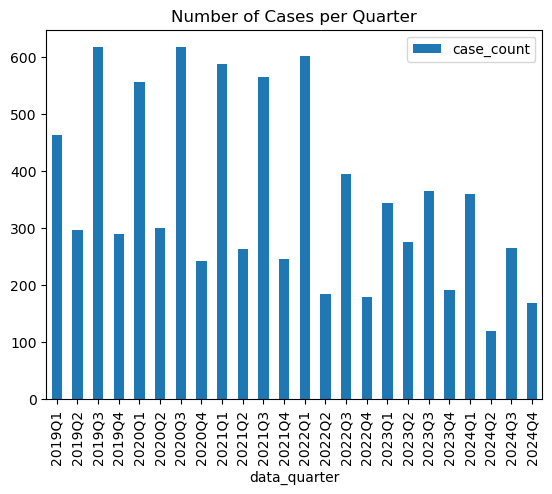

In [376]:
def plot_cases_over_time():
    query = """
    SELECT data_quarter, COUNT(*) as case_count
    FROM faers_cases
    GROUP BY data_quarter
    ORDER BY data_quarter;
    """
    df = fetch_data(query)
    df.plot(x='data_quarter', y='case_count', kind='bar', title='Number of Cases per Quarter')
    return df

plot_cases_over_time()
# print(df.head(10))


Top reported drugs plot

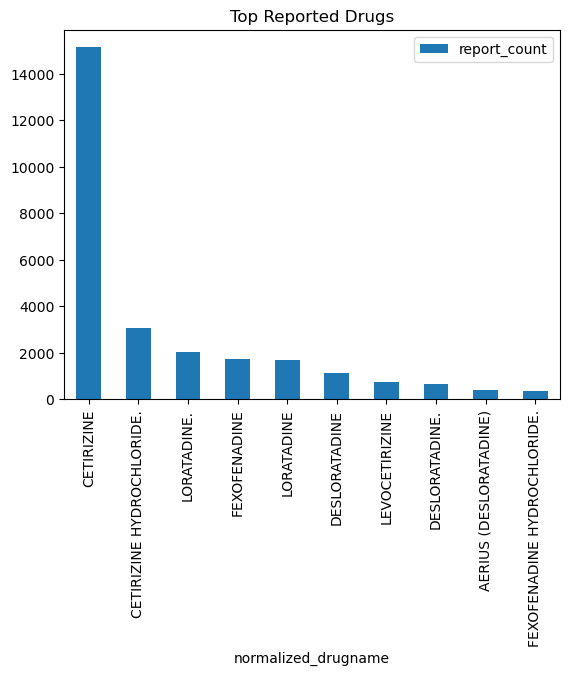

In [378]:
def plot_top_drugs(top_n=10):
    query = """
    SELECT normalized_drugname, COUNT(*) as report_count
    FROM faers_drugs
    GROUP BY normalized_drugname
    ORDER BY report_count DESC
    LIMIT 10;
    """
    df = fetch_data(query)
    df.plot(x='normalized_drugname', y='report_count', kind='bar', title='Top Reported Drugs')
plot_top_drugs()

Top adverse reactions plot

,pt,reaction_count
0,drug ineffective,1620
1,off label use,631
2,pruritus,564
3,somnolence,536
4,headache,511
5,dizziness,473
6,fatigue,422
7,product administered to patient of inappropria...,410
8,nausea,395
9,expired product administered,356


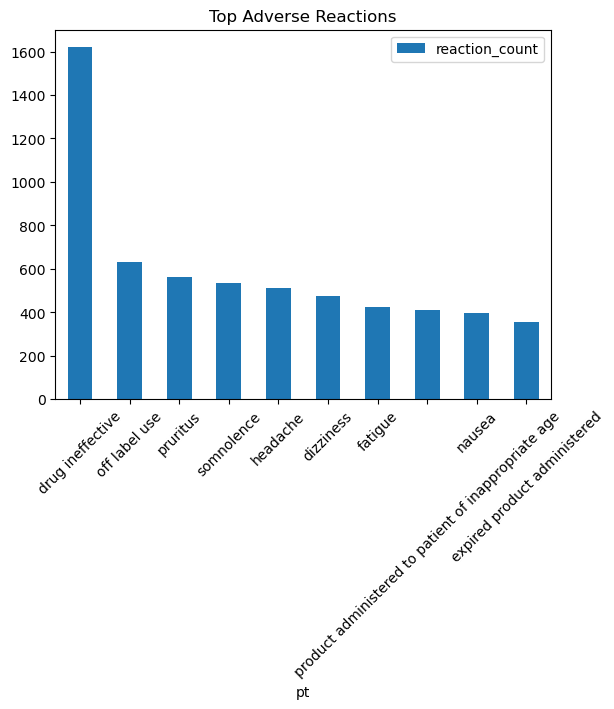

In [384]:
def plot_top_reactions(top_n=10):
    query = """
    SELECT pt, COUNT(*) as reaction_count
    FROM faers_reactions
    GROUP BY pt
    ORDER BY reaction_count DESC
    LIMIT 10;
    """
    df = fetch_data(query)
    df.plot(x='pt', y='reaction_count', kind='bar', title='Top Adverse Reactions', rot=45)
    return df

plot_top_reactions()


Reactions By Age Group

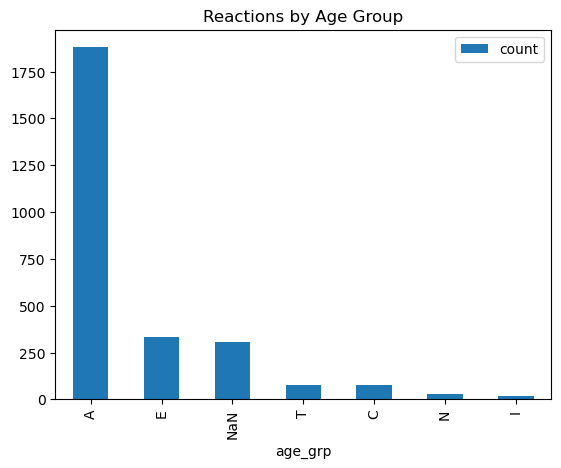

In [382]:
def plot_reactions_by_age_group():
    query = """
    SELECT age_grp, COUNT(*) as count
    FROM faers_cases
    WHERE age_grp IS NOT NULL
    GROUP BY age_grp
    ORDER BY count DESC;
    """
    df = fetch_data(query)
    df.plot(x='age_grp', y='count', kind='bar', title='Reactions by Age Group')

plot_reactions_by_age_group()


Reaction Trends Over Time

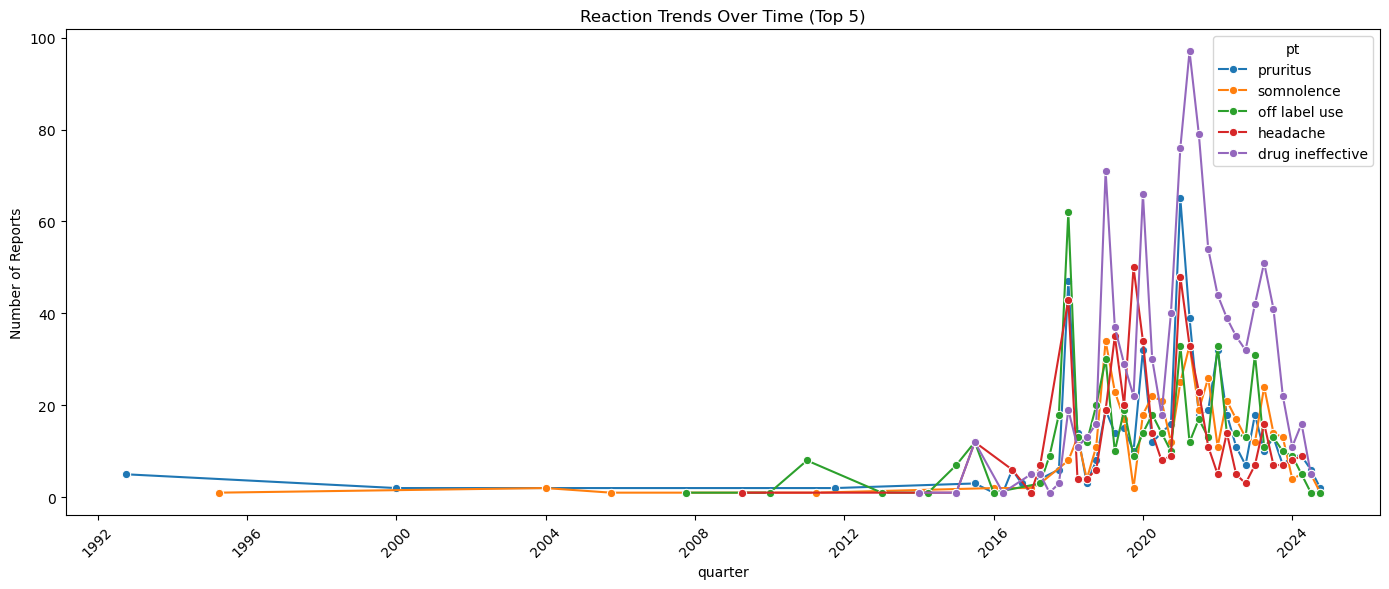

In [396]:
def plot_reaction_trend():
    query = """
    SELECT pt, DATE_TRUNC('quarter', faers_reactions.event_dt) AS quarter, COUNT(*) AS count
    FROM faers_reactions
    JOIN faers_cases USING (primaryid, caseid, caseversion)
    GROUP BY pt, quarter
    ORDER BY quarter;
    """
    df = fetch_data(query)
    plt.figure(figsize=(14, 6))
    top_pts = df.groupby('pt')['count'].sum().nlargest(5).index
    df_filtered = df[df['pt'].isin(top_pts)]
    sns.lineplot(data=df_filtered, x='quarter', y='count', hue='pt', marker='o')
    plt.title('Reaction Trends Over Time (Top 5)')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Reports')
    plt.tight_layout()
    plt.show()
plot_reaction_trend()

Drug usage by age

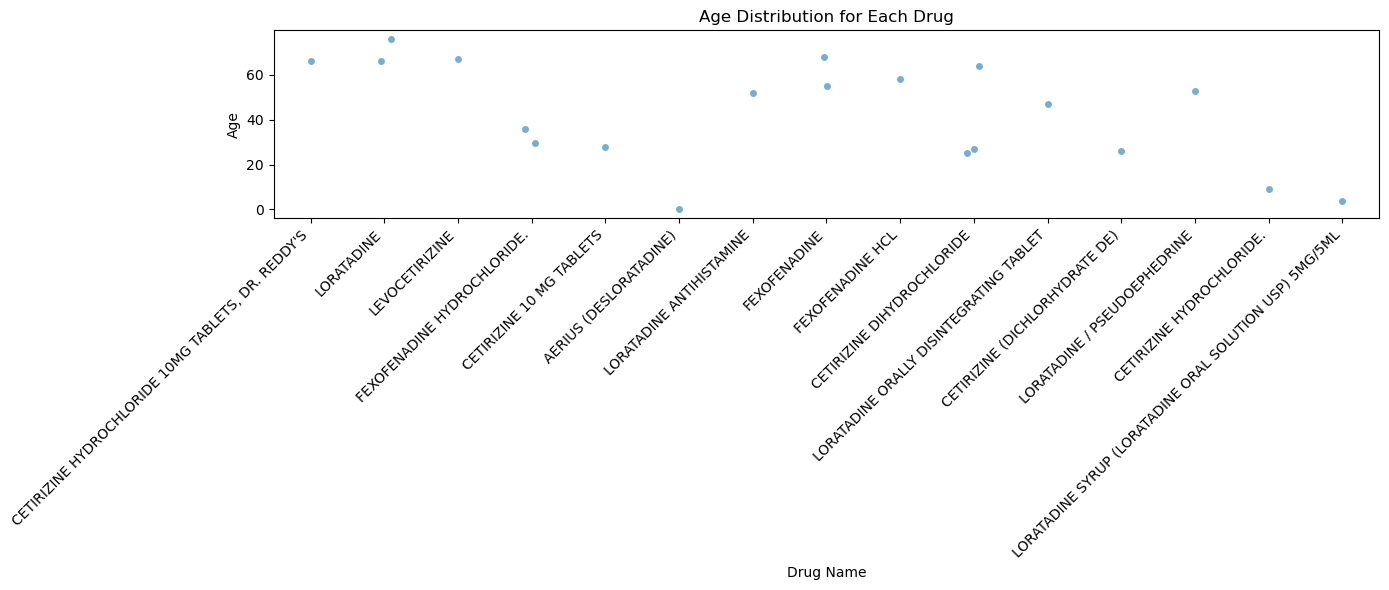

In [420]:
def drug_usage_by_age():
    query = """
    SELECT distinct normalized_drugname, age, COUNT(*) AS count
    FROM faers_drugs
    JOIN faers_cases USING (primaryid, caseid, caseversion)
    WHERE age IS NOT NULL
    GROUP BY normalized_drugname, age
    limit 20
    """
    df = fetch_data(query)
    plt.figure(figsize=(14, 6))
    sns.stripplot(data=df, x='normalized_drugname', y='age', jitter=True, alpha=0.6)
    plt.title('Age Distribution for Each Drug')
    plt.ylabel('Age')
    plt.xlabel('Drug Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

drug_usage_by_age()
    



Age Distribution by reaction

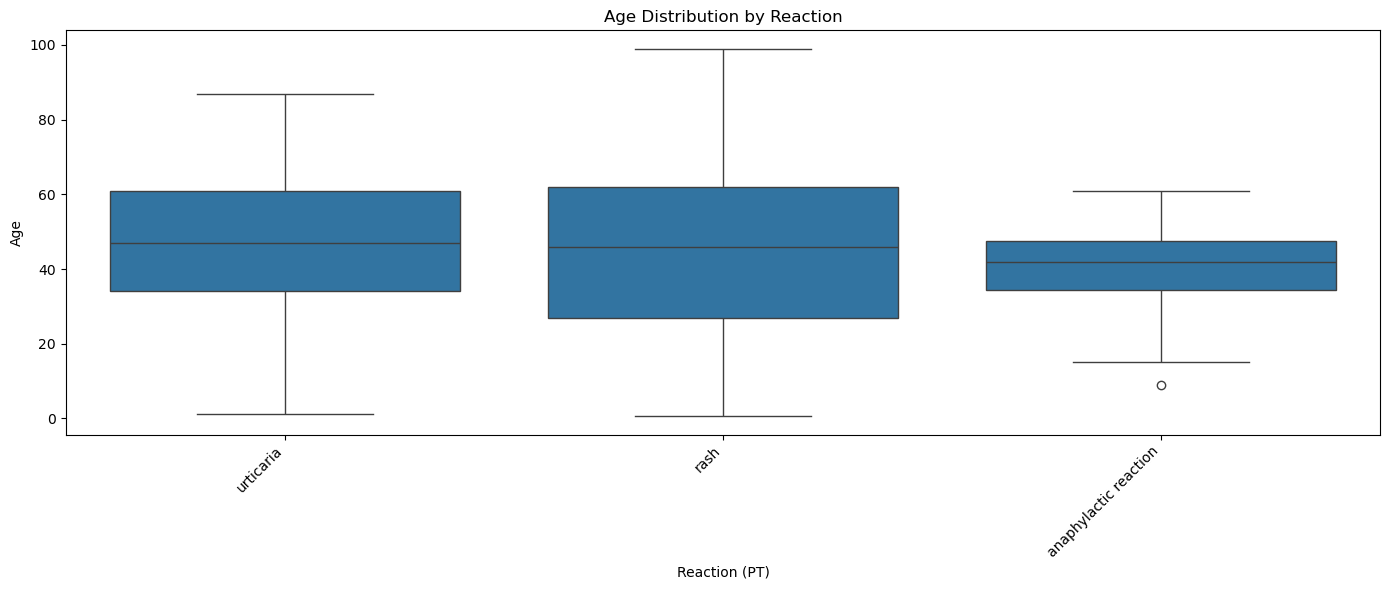

In [408]:
def age_for_reaction():
    query = """
    SELECT pt, age
    FROM faers_reactions
    JOIN faers_cases USING (primaryid, caseid, caseversion)
    WHERE age IS NOT NULL AND pt IN ('anaphylactic reaction', 'rash', 'urticaria')
    """
    df = fetch_data(query)
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x='pt', y='age')
    plt.xticks(rotation=45, ha='right')
    plt.title('Age Distribution by Reaction')
    plt.ylabel('Age')
    plt.xlabel('Reaction (PT)')
    plt.tight_layout()
    plt.show()
age_for_reaction()

Sex distribution by reaction

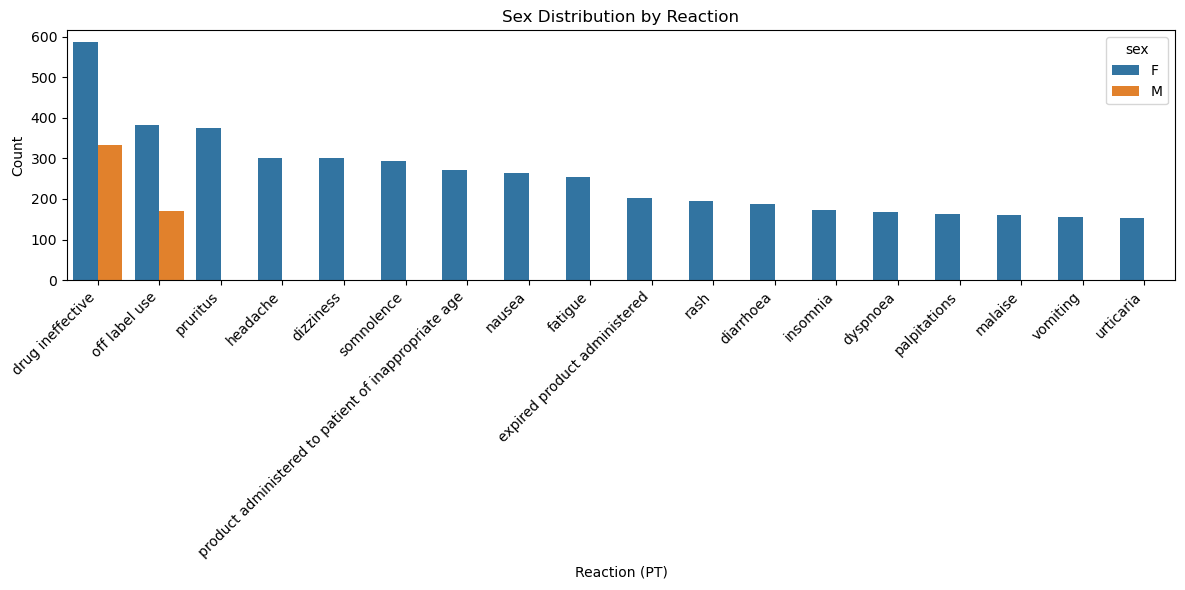

In [418]:
def sex_distribution_for_adverse_reaction():
    query = """
    SELECT sex, pt, COUNT(*) AS count
    FROM faers_reactions
    JOIN faers_cases USING (primaryid, caseid, caseversion)
    WHERE sex IS NOT NULL
    GROUP BY sex, pt
    ORDER BY count DESC
    limit 20;
    """
    df = fetch_data(query)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='pt', y='count', hue='sex')
    plt.title('Sex Distribution by Reaction')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Reaction (PT)')
    plt.tight_layout()
    plt.show()

sex_distribution_for_adverse_reaction()